In [1]:
#Imports:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from fpdf import FPDF

#Options:
sns.set_style('darkgrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
%matplotlib inline

In [2]:
def load_data():
    df = pd.read_csv('kc_house_data.csv')
    return df

In [3]:
def clean_data(df):
    df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    df.drop(['grade', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)
    df = df.reset_index()
    return df

In [4]:
def set_data(df):
    df['date'] = pd.to_datetime(df['date'])
    df_temp = df.groupby('zipcode')['price'].median().reset_index()
    df_temp.columns=['zipcode','median_price']
    df = pd.merge(df,df_temp,on='zipcode',how='inner')
    for i in range(len(df)):
        if (df.loc[i, 'date'].month == 12) | (df.loc[i, 'date'].month <= 3):
            df.loc[i, 'is_winter'] = 1
        else:
            df.loc[i, 'is_winter'] = 0
    df_temp = df[['zipcode', 'is_winter','price']].groupby(['zipcode', 'is_winter']).median().reset_index()
    df_temp = df_temp[df_temp['is_winter'] == 1].drop('is_winter', axis=1)
    df_temp.columns=['zipcode','winter_median_price']
    df = pd.merge(df, df_temp, on='zipcode', how='inner')
    df['profit_value'] = np.nan
    df['selling_price'] = np.nan
    for i in range(len(df)):
        if df.loc[i, 'is_winter'] == 0:
                if (df.loc[i, 'price'] < df.loc[i, 'median_price']) & (df.loc[i, 'condition'] >= 3):
                    df.loc[i, 'selling_price'] = round(df.loc[i, 'price']*1.2, 2)
                    df.loc[i, 'profit_value'] = df.loc[i, 'selling_price']-df.loc[i, 'price']
                    df.loc[i, 'worth_buying'] = 1
                else: 
                    df.loc[i, 'worth_buying'] = 0
        else:
                if (df.loc[i, 'price'] < df.loc[i, 'winter_median_price']) & (df.loc[i, 'condition'] >= 3):
                    df.loc[i, 'selling_price'] = round(df.loc[i, 'price']*1.2, 2)
                    df.loc[i, 'profit_value'] = df.loc[i, 'selling_price']-df.loc[i, 'price']
                    df.loc[i, 'worth_buying'] = 1
                else: 
                    df.loc[i, 'worth_buying'] = 0
    for i in range(len(df)):
        if df.loc[i, 'yr_renovated'] > 0:
            df.loc[i, 'is_renovated'] = 1
        else:
            df.loc[i, 'is_renovated'] = 0
    return df

In [5]:
def buying_list(df):
    buying_list = df[df['worth_buying'] == 1][['id','price','selling_price']].reset_index(drop=True)
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font('arial', 'B', 11)
    pdf.cell(60)
    pdf.cell(75,10, 'Worth Buying Houses Relatory', align='C')
    pdf.cell(90, 10, '', 0, 2, 'C')
    pdf.cell(-60)
    columnNameList = list(buying_list.columns)
    pdf.cell(-30, -1)
    for n in columnNameList:
        pdf.cell(35, 10,  n, 1, 0, 'C')
    pdf.cell(70, 10, ln=1)
    pdf.cell(45, ln=0)
    pdf.set_font('arial', '', 11)
    for row in range(0, len(buying_list)):
        for col_num, col_name in enumerate(columnNameList):
            if col_num != len(columnNameList)-1:
                pdf.cell(35, 10, str(buying_list['%s' % (col_name)].iloc[row]), 1, 0, 'C')
            else:
                pdf.cell(35, 10, str(buying_list['%s' % (col_name)].iloc[row]), 1, 2, 'C')
                pdf.cell(-70)
    pdf.output('buying_list.pdf')
    return buying_list


In [6]:
def insight_i():
    df1 = df.groupby(['zipcode','is_winter']).median()['price'].reset_index()
    plt.figure(figsize=(18,6))
    sns.barplot(data=df1, x='zipcode', y='price', palette='YlGnBu', hue='is_winter') 
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.xticks(rotation=60)
    plt.title('Properties prices in winter and in other seasons')
    plt.xlabel('Zipcode')
    plt.ylabel('Prices')
    plt.legend(title='Winter Season')
    plt.style.use('seaborn-dark-palette')
    cont = 0
    for i in range(len(df1)):
        if df1['is_winter'][i] == 0:
            cont += 1
            if df1['price'][i] == df1['price'].max():
                break
    plt.annotate('Max value: U$'+str(df1['price'].max()), xy=(cont-1, df1['price'].max()), horizontalalignment='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.4), xytext=((cont-1)*1.3, (df1['price'][i])*0.90))
    plt.show()


In [7]:
def insight_ii():
    sns.boxplot(data=df, x='is_renovated', y='price', palette='BuPu',)
    plt.ticklabel_format(style='plain', axis='y', useOffset=False)
    plt.xticks(np.arange(2),['Properties with no renovation','Renovated Houses'])
    plt.title('Properties prices with and without renovation')
    plt.xlabel('Renovation')
    plt.ylabel('Price')
    plt.show()

In [58]:
def insight_iii():
    df2 = df.groupby(['zipcode','waterfront'])['price'].mean().reset_index()
    for i in df2['zipcode']:
            if (2 != df2[df2.loc[:, 'zipcode'] == i]['waterfront'].shape[0]):
                df2.drop(df2[df2['zipcode'] == i].index, inplace=True)
    df2.reset_index(inplace=True, drop=True)
    df3 = df.groupby('waterfront')['price'].median().reset_index()
    df3_temp = list(zip(df3['waterfront'],df3['price'])) 
    fig = plt.figure(figsize=(13,6))
    ax1 = plt.subplot(1,2,1)
    sns.barplot(data=df3, x='waterfront', y='price', palette='inferno')
    for i in range(len(df3_temp)):
        plt.annotate('U$ '+str(df3_temp[i][1]), df3_temp[i][:2], c='black', fontsize=17, horizontalalignment='center', xytext=(i, df3_temp[i][1]*1.005))

    ax2 = plt.subplot(1,2,2)
    sns.barplot(data=df2, x='zipcode', y='price', palette='inferno',hue='waterfront')
    plt.xticks(rotation=60)
    plt.ylabel('')
    cont = 0
    cont2 = 0
    for i in range(len(df2)):
        if df2['waterfront'][i] == 1:
            cont += 1
            if df2['price'][i] == df2['price'].max():
                break
    for i in range(len(df2)):
        if df2['waterfront'][i] == 0:
            cont2 += 1
            if df2['price'][i] == df2['price'].min():
                break
    for i in range(len(df2)):
        if df2['price'][i] == df2['price'].max():
            plt.annotate('Max: U$ '+str(round(df2['price'][i],2)), xy=(cont-1+0.2, df2['price'][i]), ha='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, xytext=((cont-1)*2, df2['price'][i]*0.9), weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.7))
        elif df2['price'][i] == df2['price'].min():
            plt.annotate('Min: U$ '+str(round(df2['price'][i],2)), xy=(cont2-1, df2['price'][i]*1.1), horizontalalignment='center',  arrowprops={'facecolor':'black', 'headwidth':7.5, 'headlength':7.5, 'width':2, 'connectionstyle':"arc3,rad=.3"}, xytext=((cont2-1)*1.8, df2['price'][i]*2.1), weight='bold', bbox=dict(fc=(.7, .7, .7), lw=1, pad=5, alpha=0.7))

    ax2.set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [9]:
df = load_data()

In [10]:
df = clean_data(df)

In [11]:
df = set_data(df)

In [12]:
buying_list = buying_list(df)

In [13]:
pd.DataFrame.to_csv(df, 'reworked_kc_house_data.csv')

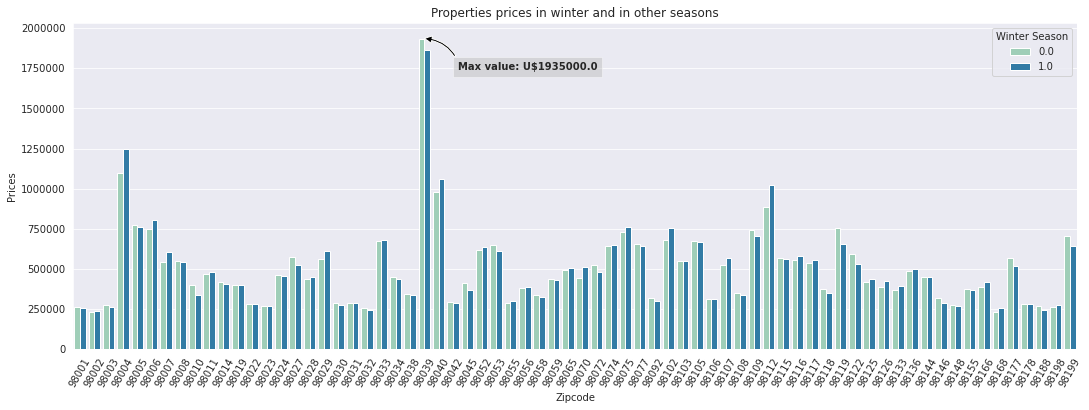

In [14]:
insight_i()

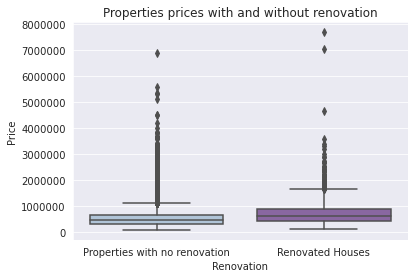

In [15]:
insight_ii()

1 4 0


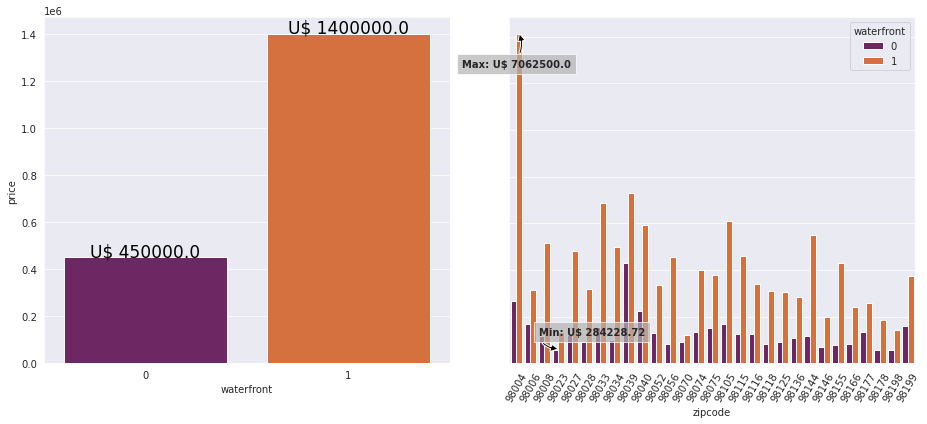

In [59]:
insight_iii()